# ***Spam Filtering for Quora questions...***

Here we are trying to buid a simple Spam filtering Deep Learning model using Word Embeddings.

In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
!pip install -U -q PyDrive

In [4]:
#Intially we will import the dataset into the Notebook..
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
downloaded= drive.CreateFile({'id': '1feloWBYp56AeekpRgWzSsui3AoRPdQo5'})
downloaded.GetContentFile('train.csv')

In [0]:
#Importing required packages...
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [0]:
spam_data= pd.read_csv('/content/train.csv')

In [4]:
spam_data.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


# **Data Preprocessing**

Process sentence...

In [0]:
#Importing required packages...
import re
import string
from nltk.tokenize import word_tokenize

In [0]:
def remove_hyperlink(word):
  return re.sub(r'http\S', '', word)

In [0]:
def to_lower(word):
  result= word.lower()
  return result

In [0]:
def remove_punctuation(word):
  result= word.translate(str.maketrans(dict.fromkeys(string.punctuation)))
  return result

In [0]:
def remove_number(word):
  result= re.sub(r'\d+', '', word)
  return result

In [0]:
def remove_whitespace(word):
  result= word.strip()
  return result

In [0]:
def replace_newline(word):
  return word.replace('\n','')

In [0]:
def clean_up_pipeline(sentence):
  cleaning_utils= [remove_hyperlink, replace_newline, to_lower, remove_number, remove_punctuation, remove_whitespace]
  for o in cleaning_utils:
    sentence= o(sentence)
  return sentence

In [0]:
spam_data['question_text']= spam_data['question_text'].apply(lambda x: clean_up_pipeline(x)) 

In [14]:
spam_data['question_text'].head(5)

0    how did quebec nationalists see their province...
1    do you have an adopted dog how would you encou...
2    why does velocity affect time does velocity af...
3    how did otto von guericke used the magdeburg h...
4    can i convert montra helicon d to a mountain b...
Name: question_text, dtype: object

# **Model Building**

As we see that we have don't have a seperate Test data to validate, hence we will split the given data into **Train** and **Test** so that we can train our Model upon **Train data** and test the results upon **Test data** as below:

In [0]:
spam_train, spam_test= train_test_split(spam_data, test_size=0.3, random_state=22)

In [0]:
x_train= spam_train['question_text']
y_train= spam_train['target']

x_test= spam_test['question_text']
y_test= spam_test['target']

In [17]:
#Validating the splitted data shapes..
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((914285,), (914285,), (391837,), (391837,))

In [18]:
#Downloading the required packages...
import nltk
nltk.download('punkt')
from nltk import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Now, we will tokenize the texts and then convert these tokens to indexed integers.

In [0]:
sent_lens=[]
for sent in x_train:
  sent_lens.append(len(word_tokenize(sent)))

In [20]:
max(sent_lens)

64

In [21]:
np.quantile(sent_lens,0.95)

27.0

In [0]:
#As we see that 95% of the sentence length stands to be as 28, hence we choose the max_len as 28  
max_len=27
tok= Tokenizer(char_level=False, split=' ')  #Tokenizing the sentences
tok.fit_on_texts(x_train)
sequences_train= tok.texts_to_sequences(x_train) #Create tokens on train
sequences_test= tok.texts_to_sequences(x_test)   #Create tokens on texts

In [20]:
vocab_len= len(tok.index_word.keys())
vocab_len

191780

In [0]:
##Importing the required packages...
from tensorflow.keras.preprocessing import sequence

In [0]:
#Now we will pad the sequences with 0 if shorter than the max_len(28)
sequence_matrix_train= sequence.pad_sequences(sequences_train, maxlen= max_len)
sequence_matrix_test= sequence.pad_sequences(sequences_test, maxlen= max_len)

In [23]:
sequence_matrix_train

array([[    0,     0,     0, ...,     6,   151,  2589],
       [    0,     0,     0, ...,  4885,    21,  1279],
       [    0,     0,     0, ...,  8266, 15892, 12327],
       ...,
       [    0,     0,     0, ...,  2081,  5887,  5057],
       [    0,     0,     0, ...,   223,    17,    22],
       [    0,     0,     0, ...,   204, 11091,    37]], dtype=int32)

In [24]:
sequence_matrix_test

array([[    0,     0,     0, ...,  1221,     6,   867],
       [    0,     0,     0, ...,     4,   144,  1193],
       [    0,     0,     0, ...,     6,  5287,   144],
       ...,
       [    0,     0,     0, ...,   136,   932,  9413],
       [    0,     0,     0, ...,   197,    21,    89],
       [    0,     0,     0, ..., 27036,   147,   269]], dtype=int32)

In [25]:
#Validating the shape of the matrices..
sequence_matrix_train.shape, sequence_matrix_test.shape

((914285, 27), (391837, 27))

In [81]:
#Downloading the Embedding to use the pre-trained weights.. 
!wget http://nlp.stanford.edu/data/glove.twitter.27B.zip

--2020-02-19 07:43:11--  http://nlp.stanford.edu/data/glove.twitter.27B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.twitter.27B.zip [following]
--2020-02-19 07:43:11--  https://nlp.stanford.edu/data/glove.twitter.27B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip [following]
--2020-02-19 07:43:12--  http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520408563 (1.4G) [appli

In [85]:
#unzipping it..
!unzip glove.twitter.27B.zip

Archive:  glove.twitter.27B.zip
  inflating: glove.twitter.27B.25d.txt  
  inflating: glove.twitter.27B.50d.txt  
  inflating: glove.twitter.27B.100d.txt  
  inflating: glove.twitter.27B.200d.txt  


In [0]:
embedding_index={}

f=open('glove.twitter.27B.200d.txt', encoding='utf-8')
for line in f:
  values= line.split()
  word= values[0]
  coefs= np.asarray(values[1:], dtype='float32')
  embedding_index[word]= coefs
f.close()

Creating our Embedding matrix to bring the size to 300.
We will use 300D vector representation of the words from pre-trained Embedding vector that we downloaded...

In [0]:
embedding_matrix= np.zeros((vocab_len+1, 200))

for word, i in tok.word_index.items():
  embed_vector= embedding_index.get(word)
  if embed_vector is not None:
    embedding_matrix[i]== embed_vector

In [0]:
##Importing the required packages...
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, BatchNormalization
from tensorflow.keras.models import Model

## **Network architecture**
Embedding layer has to come first and takes the embedding matrix and input_length arguments we specified earlier. I've set this to be not trainable to begin with.

In [106]:
#Defining the Model...
inputs= Input(name='text_input', shape=[max_len])
embed= Embedding(vocab_len+1, 200, input_length=max_len, mask_zero=True, weights=[embedding_matrix],trainable=False, name='Embedding_layer')(inputs)
lstm_layer= LSTM(512, name='LSTM_Layer')(embed)
bn1= BatchNormalization()(lstm_layer)
dense1= Dense(128, activation='tanh', name='Dense_Layer1')(bn1)
bn2= BatchNormalization()(dense1)
drop1= Dropout(0.2, name='Dropout_Layer1')(bn2)
dense2= Dense(16, activation='tanh', name='Dense_Layer2')(drop1)
bn3= BatchNormalization()(dense2)
drop2= Dropout(0.2, name='Dropout_Layer2')(bn3)
final_layer= Dense(1, activation= 'sigmoid', name='Final_Layer')(drop2)
model= Model(inputs= inputs, outputs= final_layer)

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_input (InputLayer)      [(None, 27)]              0         
_________________________________________________________________
Embedding_layer (Embedding)  (None, 27, 200)           38356200  
_________________________________________________________________
LSTM_Layer (LSTM)            (None, 512)               1460224   
_________________________________________________________________
batch_normalization_3 (Batch (None, 512)               2048      
_________________________________________________________________
Dense_Layer1 (Dense)         (None, 128)               65664     
_________________________________________________________________
batch_normalization_4 (Batch (None, 128)               512       
_________________________________________________________________
Dropout_Layer1 (Dropout)     (None, 128)               0   

# **Training and Evaluation**

In [0]:
#Now we will train our model...
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

**Defining Callbacks for saving our model with certain constraints..**

In [31]:
from tensorflow.keras.callbacks import ModelCheckpoint
import os

output_folder= './Quora_SpamHam_output'
if not os.path.exists(output_folder):
  os.makedirs(output_folder)

filepath= output_folder+"/weights-{epoch:02d}-accuracy-{accuracy:.4f}.h5"
checkpoint= ModelCheckpoint(filepath, verbose=1, monitor='accuracy',
                            save_best_only=False,
                            save_weights_only=True,
                            mode='auto', period=4) #This will save the weights every 5 epochs

In [32]:
#We see that the target variable here has the imbalanced dataset as shown below:
spam_train['target'].value_counts()

0    857610
1     56675
Name: target, dtype: int64

In [33]:
#Defining class weights to balance the dataset...
from sklearn.utils import class_weight
class_weights= class_weight.compute_class_weight('balanced',np.unique(y_train), y_train)  #This produces an array

class_weights= dict(enumerate(class_weights))  #We changed it to dictionary in order to work with keras.
class_weights

{0: 0.5330424085540048, 1: 8.066034406704896}

In [0]:
model.fit(sequence_matrix_train, y_train.values, validation_data=[sequence_matrix_test, y_test.values],
          epochs=20, class_weight={0:1, 1:8}, batch_size=2000, verbose=1, callbacks=[checkpoint])

In [0]:
#Now load the saved model for prediction..
model.load_weights('/content/Quora_SpamHam_output/weights-38-accuracy-0.8959.h5')

In [74]:
#Predicting the model..
from sklearn.metrics import roc_auc_score, roc_curve, classification_report,f1_score
predict= model.predict(sequence_matrix_test, verbose=1)

391837/391837 [==============================] - 100s 255us/sample


roc_auc_score:  0.6611943824899766


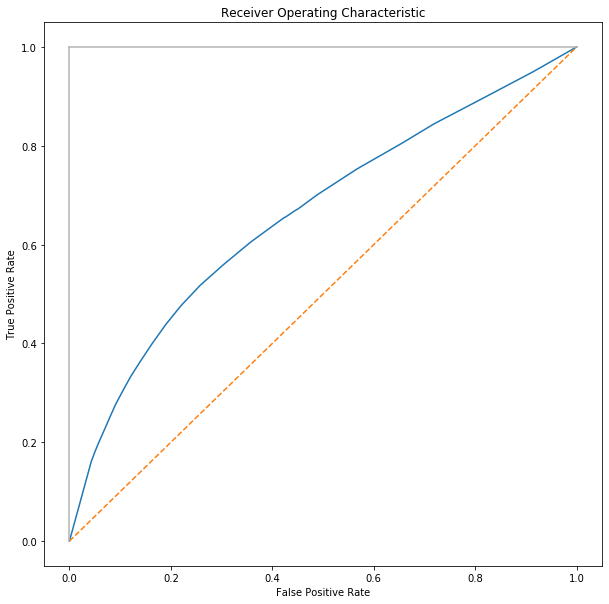

In [76]:
#Plotting ROC_AUC_CURVE for finalizing cut-off...
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, predict)
print('roc_auc_score: ', roc_auc_score(y_test, predict))

# Plot ROC curves
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [93]:
roc_auc_score(y_test,predict>0.30)

0.629887786977028

In [94]:
print(f1_score(y_test, predict>0.30))

0.1901830675818776


In [96]:
print(classification_report(y_test, predict>0.30))

              precision    recall  f1-score   support

           0       0.96      0.74      0.84    367702
           1       0.12      0.52      0.19     24135

    accuracy                           0.73    391837
   macro avg       0.54      0.63      0.51    391837
weighted avg       0.91      0.73      0.80    391837



In [104]:
predict[3]>0.30

array([ True])

In [0]:
#Saving the model..
model.save('./Quora_SpamFiltering_model.h5')